In [62]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset, WFLWDataset, AnimalDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

Running on device: cuda


In [64]:
data_loc = '/home/data/animal/'

train_dataset = AnimalDataset(data_loc + 'animal_train.csv', data_loc + 'animal_dataset_v1_clean_check',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.RandomRotation(20),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)

val_dataset = AnimalDataset(data_loc + 'animal_test.csv', data_loc + 'animal_dataset_v1_clean_check',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)

test_dataset = AnimalDataset(data_loc + 'animal_test.csv', data_loc + 'animal_dataset_v1_clean_check',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

In [65]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

animal_baseline_resnet_nopretrain_transforms_1/
animal_baseline_resnet_wingloss_1/
celeba_baseline_resnet_wingloss_1/
wflw_baseline_resnet_wingloss_1/
wflw_baseline_resnet_wingloss__notransform_1/


In [66]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/animal_baseline_resnet_wingloss_1"

checkpoint_0/   checkpoint_2/  checkpoint_6/  checkpoint_batch_0/
checkpoint_1/   checkpoint_3/  checkpoint_7/
checkpoint_10/  checkpoint_4/  checkpoint_8/
checkpoint_11/  checkpoint_5/  checkpoint_9/


In [67]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/animal_baseline_resnet_wingloss_1/checkpoint_11/results.csv"
model_results = pd.read_csv(model_path)

In [68]:
num_landmarks = 9
y = model_results['y'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
y_pred = model_results['y_pred'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
print(y.shape, y_pred.shape)

# To convert into (NxD) just change view

(2246, 9, 2) (2246, 9, 2)


In [122]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
        
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


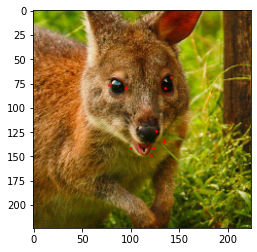

Truth


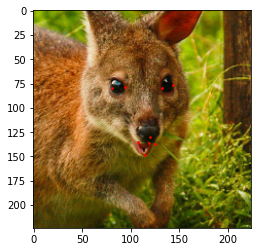

KeyError: 'attributes'

In [123]:
#0
img_num = 10

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()
print(sample['attributes'])

# Only run once to generate predictions

In [101]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

celeba_baseline_resnet_1/             wflw_baseline_resnet_pretrain_1/
celeba_baseline_resnet_nopretrain_1/  wflw_baseline_resnet_pretrain_2/
celeba_baseline_simplenet_1/          wflw_baseline_simplenet_1/
wflw_baseline_resnet_nopretrain_1/


In [102]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_nopretrain_1/"

checkpoint_0/   checkpoint_15/  checkpoint_21/  checkpoint_6/
checkpoint_1/   checkpoint_16/  checkpoint_22/  checkpoint_7/
checkpoint_10/  checkpoint_17/  checkpoint_23/  checkpoint_8/
checkpoint_11/  checkpoint_18/  checkpoint_24/  checkpoint_9/
checkpoint_12/  checkpoint_19/  checkpoint_3/   checkpoint_batch_0/
checkpoint_13/  checkpoint_2/   checkpoint_4/
checkpoint_14/  checkpoint_20/  checkpoint_5/


In [6]:
model_path = "//home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/animal_baseline_resnet_wingloss_1/checkpoint_11/model.pt"
model = torch.load(model_path).to(device)

In [7]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=9*2, device=device)

100%|██████████| 562/562 [02:36<00:00,  3.59it/s]


In [8]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path, index=False)

# Evaluation

In [71]:
# load data and predictions
x = pd.read_csv(data_loc+'animal_test.csv').values
y_hat = y_pred[:, :, :]
y_new = y[:, :, :]

num_samples = len(x)
total_size = len(x[0][0].split()[:-1])

#x = [x[i][0].split()[:-1] for i in range(num_samples)]
x = np.asarray(x[:,1:], dtype=np.float)

num_samples, num_features = x.shape

assert(y_hat.shape == y_new.shape)
print('Num_samples:', num_samples) 
print('Num_features:', num_features) 

Num_samples: 2246
Num_features: 18


In [151]:
# define d to be either interocular distance or bounding box diagonal length
d = np.array([1*2**0.5]*num_samples)

In [152]:
print(d, d.shape)

[1.41421356 1.41421356 1.41421356 ... 1.41421356 1.41421356 1.41421356] (2246,)


In [153]:
"""
Z = list of lists, where each entry is [sensitive attribute column number, majority condition]
alpha = failure rate threshold   
calculate_landmark: if True, calculates certain bias metrics overall and per landmark. if false, only overall
"""
counts = np.sum(x, axis=0)
maj = np.where(counts > num_samples/2, 1, 0)
Z = [[i,maj[i]] for i in range(num_features)]

alpha = 0.2
beta = 1
# calculate_landmark = True

In [154]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of n x m
d is the interocular distance
"""

def calc_nme_images(y_hat, y, m, d):
    # Output: NME of each image over all landmarks (size n)
    nme = np.linalg.norm(y_hat-y, axis=-1) / d[:, np.newaxis]
    return nme.mean(axis=1)

def calc_nme_landmark(y_hat, y, m, d):
    # Output: NME of each image for each facial landmark (size n x m/2)
    nme = np.linalg.norm(y_hat-y, axis=-1) / d[:, np.newaxis]
    return nme

def calc_total_nme(nme):
    # Output: average NME across all images
    return np.mean(nme, axis=0)

def create_ced(nme):
    # Output: plot of the CED
    x = np.sort(nme)
    y = np.arange(nme.shape[0]) / float(nme.shape[0])
    plt.xlabel('Normalized Mean Error (NME)')
    plt.ylabel('Percent of Samples')
  
    plt.title('Plot of Cumulative Error Distribution (CED) Curve')
    plt.plot(x, y, marker='o')
    plt.show

def calc_auc(nme, alpha):
    # Output: percentage of samples with nme=0 to alpha
    num_under_alpha = np.where(nme < alpha, 1, 0)
    return np.sum(num_under_alpha) / nme.shape[0]

def calc_fr(nme, alpha):
    # Output: failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
    return 1-calc_auc(nme, alpha)

In [155]:
nme_images = calc_nme_images(y_hat, y_new, num_landmarks, d)
nme_landmark = calc_nme_landmark(y_hat, y_new, num_landmarks, d)
total_nme = calc_total_nme(nme_images)
total_nme_landmark = calc_total_nme(nme_landmark)
fr = calc_fr(nme_images, alpha)

print('Average Normalized Mean Error:', total_nme, '\n')
print('Average Normalized Mean Error Per Landmark')
for i in range(num_landmarks):
    print(f'Landmark {i}: {total_nme_landmark[i]}')
print('\n')
print(f'Failure Rate Threshold at {alpha}: {fr}')

Average Normalized Mean Error: 0.032128721203325876 

Average Normalized Mean Error Per Landmark
Landmark 0: 0.028517048782898055
Landmark 1: 0.022405069335708197
Landmark 2: 0.028618387710384486
Landmark 3: 0.038242512365090936
Landmark 4: 0.031231246386576886
Landmark 5: 0.04355805843430486
Landmark 6: 0.03794366649993161
Landmark 7: 0.0316863968890344
Landmark 8: 0.026956104426003383


Failure Rate Threshold at 0.2: 0.0


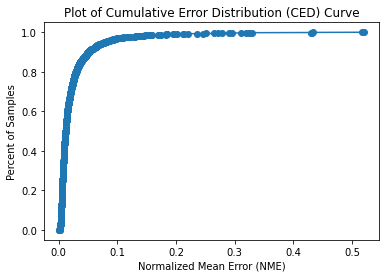

In [50]:
ced = create_ced(nme_images)

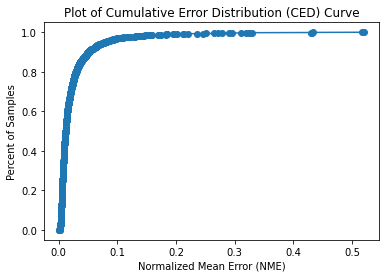

In [51]:
no_outliers = nme_images[np.where(nme_images<beta)]
ced = create_ced(no_outliers)

In [249]:
"""Bias Metrics: Majority/Minority Difference in Error/Failure (MMD)"""
def calc_mmd_err(majority, minority):
    difference = np.mean(majority, axis=0) - np.mean(minority, axis=0)
    return difference

def calc_mmd_fr(majority, minority, alpha):
    difference = calc_fr(majority, alpha) - calc_fr(minority, alpha)
    return difference

In [250]:
""" Within each loop:
z = sensitive attribute group (as column number)
maj = value of majority group
nme = num_samples dimension tensor
"""

mmd_err = {}
mmd_fr = {}


# if calculate_landmark:
#     mmd_error_landmarks = {}

# calculates MMD Error and MMD Failure averaged across all landmarks
for z, maj in Z:
    majority = nme_images[np.where(x[:, z] == maj)] # size # images in majority
    minority = nme_images[np.where(x[:, z] != maj)] # size # images in minority

    mmd_err[z] = calc_mmd_err(majority, minority)
    mmd_fr[z] = calc_mmd_fr(majority, minority, alpha)

# calculates MMD Error for each landmark    
# if calculate_landmark:
#     for z, maj in Z:
#         majority = nme_landmark[np.where(x[:, z] == maj)] # size # images in majority x m/2
#         minority = nme_landmark[np.where(x[:, z] != maj)] # size # images in minority x m/2
#         mmd_error_landmarks[z] = calc_mmd_err(majority, minority)

In [251]:
print('MMD in Error per Attribute')
for z, error in mmd_err.items():
    print(f'Attribute {z}: {error}')

MMD in Error per Attribute
Attribute 0: -0.13883534916897516
Attribute 1: 0.01728137963813664
Attribute 2: 0.024891603248500732
Attribute 3: 0.0012438310036854971
Attribute 4: -0.0463550217957171
Attribute 5: -0.02658068918183082


In [252]:
print('MMD in Failure Rate')
for z, error in mmd_fr.items():
    print(f'Attribute {z}: {error}')

MMD in Failure Rate
Attribute 0: -0.21131059093899185
Attribute 1: -0.01198676558469014
Attribute 2: 0.03815613420751596
Attribute 3: -0.014825619551272484
Attribute 4: -0.08102388468272959
Attribute 5: -0.029252030058507072
